In [1]:
#libraries
from scipy.signal import butter, filtfilt, spectrogram
import scipy.signal as sis
import scipy.stats as ss
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from feature_selector import FeatureSelector

In [2]:
# %matplotlib qt

#### Loading dataset

In [3]:
import sys
sys.path.append('../')
from Participants import Participants
participant = Participants("../data/participants")

In [4]:
signal = participant[0][0][10]
signal1 = participant[0][0][0]
signal.shape

(299900,)

#### EEG rhythms:
$\alpha = 8-13 \text{Hz}, \ \ \beta = 13-30 \text{Hz},  \ \ \delta = 0.5-4 \text{Hz},  \ \ \theta = 4-8 \text{Hz},  \ \ \gamma = 30-60 \text{Hz}$ 

In [13]:
def bandpass_filter(signal, low_cutoff, high_cutoff, sample_rate, order=4):
    nyquist_freq = 0.5 * sample_rate
    low = low_cutoff / nyquist_freq
    high = high_cutoff / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [14]:
fs = 500
N = len(signal) 
time = np.arange(N) / fs

In [15]:
alpha_rhythm = bandpass_filter(signal, 8, 13, fs)
beta_rhythm = bandpass_filter(signal, 13, 30, fs)
delta_rhythm = bandpass_filter(signal, 0.5, 4, fs)
theta_rhythm = bandpass_filter(signal, 4, 8, fs)
gamma_rhythm = bandpass_filter(signal, 30, 60, fs)

No handles with labels found to put in legend.


[-12.06543508 -11.78954335 -11.50417196 ...   0.06362086   0.05512465
   0.0474546 ]


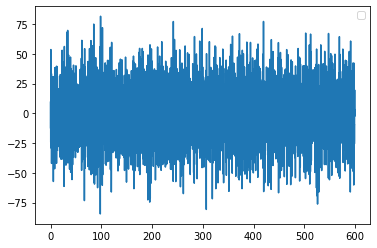

In [16]:
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot(time, delta_rhythm)
plt.legend()
print(delta_rhythm)

In [61]:
from scipy.io import loadmat
data = loadmat(r"C:\Users\DELL\Documents\Onlajn nastava\Treća godina\Šesti semestar\AES\Projekat\dataset\sub-001\eeg\sub-001_task-eyesclosed_eeg.set")

In [67]:
signal_raw = data['data'][10]
signal_raw1 = data['data'][0]
signal_raw.shape

(299900,)

In [68]:
%matplotlib qt

In [74]:
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot(time, signal, label='Processed')
plt.plot(time, signal_raw, label='Raw')
plt.legend()

plt.figure(4)
plt.plot(time, signal1, label='Processed')
plt.plot(time, signal_raw1, label='Raw')
plt.legend()

In [75]:
def plot_spect(data, N, fs, label):
    freq_data = 2 * (np.fft.fft(data) / N)[:N//2+1]
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2+1]
    plt.plot(freqs, np.abs(freq_data), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 70])
    plt.title('One-Sided Spectrum')
    plt.legend()
    plt.show()

In [76]:
plt.figure(2)
plot_spect(signal_raw, N, fs, 'raw')
plot_spect(signal, N, fs, 'processed')


In [77]:
plt.figure(3)
plot_spect(signal_raw1, N, fs, 'raw')
plot_spect(signal1, N, fs, 'processed')


#### Comparing basic features between subjects

In [78]:
n_channels = participant[0][0].shape[0]
n_participants = len(participant.name)

In [79]:
sub1, sub2 = 19, 41
signal0 = participant[sub1][0][0]
signal1 = participant[sub2][0][0]
print("MMSE score of first subject is {} and of second {}".format(participant[sub1][4], participant[sub2][4]))

MMSE score of first subject is 4 and of second 30


### Comparing amplitudes of alpha and theta rhythms

In [51]:
def get_power_band(band, participant_id = -1, channel = -1):
    band_to_freq = {'alpha':[8, 13], 'beta':[13, 30], 'theta':[4, 8]}
    freq = band_to_freq[band]

    powers = np.empty(n_participants)
    if participant_id == -1 and channel == -1:
        for i in range(n_participants):
            for j in range(n_channels):
                signal = participant[i][0][j]
                signal = bandpass_filter(signal, freq[0], freq[1], fs)
                powers[i] += np.sum(np.square(signal))/len(signal)
            powers[i] /= n_channels
    return powers

In [52]:
band = 'alpha'
powers = get_power_band(band)
np.max(powers)

117.82504690224236

In [53]:
import seaborn as sns

groups = [participant[i][3] for i in range(n_participants)]
data = pd.DataFrame({'power':powers, 'group':groups})
fig, axs = plt.subplots(1, 3)

fig.suptitle("Distribution of signal power in {} band, all chanels combined".format(band))
sns.histplot(ax = axs[0], data=data[data['group']=='C'], x = "power", hue = "group")
# axs[0].set_xlim([0, 80])
# axs[0].set_ylim([0, 15])
sns.histplot(ax = axs[1], data=data[data['group']=='F'], x = "power", hue = "group")
# axs[1].set_xlim([0, 80])
# axs[1].set_ylim([0, 15])
sns.histplot(ax = axs[2], data=data[data['group']=='A'], x = "power", hue = "group")
# axs[2].set_xlim([0, 80])
# axs[2].set_ylim([0, 15])

<AxesSubplot:xlabel='power', ylabel='Count'>

In [54]:
def get_group_power_data(data, group):
    return np.array(data[data['group']==group]['power'])

In [55]:
group_names = ['C', 'F', 'A']
stds, means = {}, {}
for g in group_names:
    stds[g] = np.std(get_group_power_data(data, g))
    print('std of power in alpha band for group {} is {}'.format(g, np.std(get_group_power_data(data, g))))
for g in group_names:
    means[g] = np.mean(get_group_power_data(data, g))
    print('mean of power in alpha band for group {} is {}'.format(g, np.mean(get_group_power_data(data, g))))

std of power in alpha band for group C is 25.220679706617528
std of power in alpha band for group F is 10.82436333956598
std of power in alpha band for group A is 9.870373639076542
mean of power in alpha band for group C is 36.4002822154619
mean of power in alpha band for group F is 20.612768438375443
mean of power in alpha band for group A is 19.90033698658212


#### Wavelet transform and PSD

In [50]:
import pywt

# first we divide signal in epochs with overlap

epoch_length = 5*fs
overlap_length = int(2.5*fs)

signal = participant[sub1][0][0]
print("Shape of original signal: " + str(signal.shape))
signal_epochs = np.array([signal[i:i+epoch_length] for i in range(0, len(signal)-epoch_length+1, overlap_length)])
print("Shape of signal divided into epochs: " + str(signal_epochs.shape))

Shape of original signal: (434650,)
Shape of signal divided into epochs: (346, 2500)


In [71]:
wavelet = 'db2'  # Wavelet type
level = 6        # Decomposition level

coeffs = pywt.wavedec(signal, wavelet, level=level)
approx_coeffs = coeffs[0]
detail_coeffs = coeffs[1:]


AttributeError: module 'pywt' has no attribute 'power_spectrum'